In [22]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy import stats
from sklearn import metrics
import seaborn as sns
sns.set_theme(style='whitegrid')

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from IPython.display import SVG
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True # Change output to SVG format
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400,400

In [23]:
import matplotlib.pyplot as plt

# config
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'font.size': 16})

# Change Matplotlib font to Helvetica
import matplotlib as mpl
import matplotlib.font_manager as fm
mpl.rcParams['font.family'] = 'Helvetica'
fm.findfont("Helvetica", fontext="ttx", rebuild_if_missing=False)

'/System/Library/Fonts/Helvetica.ttc'

In [24]:
import lightgbm as lgb
sys.path.append('/Users/nicolairee/KU_data/peder_xai/smi2gcs')
from DescriptorCreator.GraphChargeShell import GraphChargeShell

gcs_generator = GraphChargeShell()

SQM folder is: 
/Users/nicolairee/KU_data/esnuelML/calculations


In [25]:
def remove_identical_atoms(rdkit_mol, atom_list):
    idx_list = []
    rank_kept = []
    atom_rank = list(Chem.CanonicalRankAtoms(rdkit_mol, breakTies=False))
    for idx, atom in enumerate(atom_list):
        if atom_rank[atom] not in rank_kept:
            rank_kept.append(atom_rank[atom])
            idx_list.append(idx)
    
    atom_list = np.array(atom_list)[idx_list].tolist()
    return atom_list

# Run MAA predictions

In [26]:
# final_model = lgb.Booster(model_file='/Users/nicolairee/Desktop/steno/postdoc/applications/esnuelML/MLmodel/elec/SMI2GCS_3_cm5/final_best_model.txt')
# final_model = lgb.Booster(model_file='/Users/nicolairee/Desktop/steno/postdoc/applications/esnuelML/MLmodel/elec/SMI2GCS_3_cm5/train_with_GCS_3_cm5_hyperparameters/final_best_model.txt')

# final_model = lgb.Booster(model_file='/Users/nicolairee/Desktop/steno/postdoc/applications/esnuelML/MLmodel/elec/SMI2GCS_5_cm5/final_best_model.txt')

# final_model = lgb.Booster(model_file='/Users/nicolairee/Desktop/steno/postdoc/applications/esnuelML/MLmodel/elec/RDKitGasteigerGCS_5/final_best_model.txt')

In [28]:
import gzip

# lgb_model_path = '/Users/nicolairee/Desktop/steno/postdoc/applications/esnuelML/MLmodel/elec/SMI2GCS_3_cm5/train_with_GCS_3_cm5_hyperparameters/SMI2GCS_3_cm5_model.txt.gz'
lgb_model_path = '/Users/nicolairee/KU_data/esnuelML/ESNUEL_ML/models/elec/SMI2GCS_3_cm5_model.txt.gz'
with gzip.open(lgb_model_path, mode="rt") as file:
    lgb_model_str = file.read()

final_model = lgb.Booster(model_str=lgb_model_str)

Finished loading model, total used 322 iterations


In [29]:
sys.path.append('/Users/nicolairee/KU_data/peder_xai/smi2gcs')
from DescriptorCreator.NodeDescGenerator import NodeDescGenerator

def atomicGasteigerChargeDescriptor(smiles, atom_sites, n_shells=5):

    rdkit_molHs = Chem.AddHs(Chem.MolFromSmiles(smiles))

    Chem.rdPartialCharges.ComputeGasteigerCharges(rdkit_molHs)
    rdkit_charges = [float(atom.GetProp('_GasteigerCharge')) for atom in rdkit_molHs.GetAtoms()]

    NodeDescGen = NodeDescGenerator(molobj = rdkit_molHs,
                                    property_list = rdkit_charges,
                                    n_shells = n_shells,
                                    max_neighbors = 4,
                                    use_cip_sort = True)

    descriptor_vectors = []
    for atom_site in atom_sites:
        atom_descriptor, atom_mapper = NodeDescGen.calculate_descriptor(atom_site)
        descriptor_vectors.append(atom_descriptor)

    return descriptor_vectors

In [30]:
def gen_atom_desc(smiles, atom_sites, n_shells=3):

    name = hashlib.md5(Chem.MolToSmiles(Chem.MolFromSmiles(smiles)).encode()).hexdigest()

    file_path = f'calculations/{name}/xtb.out'
    if os.path.isfile(file_path):
        rdkit_molHs = Chem.AddHs(Chem.MolFromSmiles(smiles))

        # Get CM5 charges from output and append CM5 charges to RDKit mol object 
        cm5_list = []
        natoms = int(rdkit_molHs.GetNumAtoms())
        with open(file_path, 'r') as output:
            for line_idx, line in enumerate(output):
                if 'Mulliken/CM5' in line:
                    start = line_idx + 1
                    endindex = start + natoms
                    for i in range(start, endindex):
                        line = output.readline(i)
                        cm5_atom = float(line.split()[2])
                        cm5_list.append(cm5_atom)
                    break
        
        gcs_generator.rdkit_mol = rdkit_molHs
        gcs_generator.cm5_list = cm5_list
    else:
        cm5_list = gcs_generator.calc_CM5_charges(smiles, name=name, optimize=False, save_output=True)
    
    descriptor_vector, mapper_vector = gcs_generator.create_descriptor_vector(atom_sites, n_shells=n_shells, max_neighbors=4, use_cip_sort=True)
    return descriptor_vector

In [31]:
def run_preds(smiles:str, atom_sites_list:list[int]):

    descriptor_vectors = gen_atom_desc(smiles, atom_sites_list, n_shells=3)
    # descriptor_vectors = atomicGasteigerChargeDescriptor(smiles, atom_sites_list, n_shells=5)
    preds = final_model.predict(descriptor_vectors, num_iteration=final_model.best_iteration)

    # print(descriptor_vectors)

    return preds

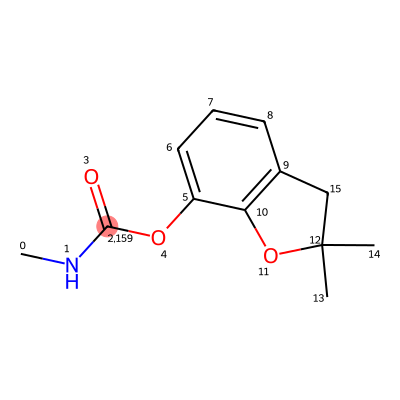

In [67]:
smiles = 'CNC(=O)Oc1cccc2c1OC(C)(C)C2'
atom_sites_list = [2]

# smiles = 'BrC(Br)c1csc(-c2ccccc2)n1'
# atom_sites_list = [3,4,6,7,8,9,10,11,12,13] # correct 4

rdkit_mol = Chem.MolFromSmiles(smiles)
predMAAs = run_preds(smiles, atom_sites_list)

for atom_site, predMAA in zip(atom_sites_list, predMAAs):
    rdkit_mol.GetAtomWithIdx(atom_site).SetProp("atomNote", f'{predMAA:.0f}')
rdkit_mol.__sssAtoms = [atom_sites_list[np.argmax(predMAAs)]]
rdkit_mol

# Tebes-stevens data

In [43]:
df_stevens = pd.read_csv('/Users/nicolairee/KU_data/hydrolysis/A multiple linear regression approach to the estimation of carboxylic acid ester and lactone alkaline hydrolysis rate constants/stevens_data.csv')
print(df_stevens.shape[0])
df_stevens.head(2)

29


,name,smiles,calc_maa,calc_error,pred_maa,DT50val (ph:7),real_name,ref
0,125,CNC(=O)Oc1cccc2c1OC(C)(C)C2,269.073859,True,149.178535,24.0,Carbofuran,"EFSA (European Food Safety Authority), 2004a. ..."
1,122,CNC(=O)Oc1cccc2c1OC(C)(C)O2,268.203134,True,155.689072,2.0,Bendiocarb,Bendiocarb - WHO Specifications and Evaluation...


In [44]:
selected_pH = 'ph7'
smiles_list = df_stevens['smiles'].tolist()
DT50val_list = df_stevens['DT50val (ph:7)'].tolist()
calc_maa_list = df_stevens['calc_maa'].tolist()
any_errors_list = df_stevens['calc_error'].tolist()
pred_maa_list = []

In [45]:
# selected_pH = 'ph7'
# smiles_list = ['CNC(=O)Oc1cccc2c1OC(C)(C)C2', 'CNC(=O)Oc1cccc2c1OC(C)(C)O2', 'CCOC(=O)CCN(SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2)C(C)C', 'COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(C)nc(OC)n1', 'CC(=O)OC(C)=O', 'CC1(C)C(=O)OC(=O)C1(C)C', 'COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(OC(F)F)cc(OC(F)F)n1', 'CC(C)=NOCCOC(=O)[C@@H](C)Oc1ccc(Oc2cnc3cc(Cl)ccc3n2)cc1', 'COC(=O)c1cccc(C)c1S(=O)(=O)NC(=O)Nc1nc(OCC(F)(F)F)nc(N(C)C)n1', 'CCOC(=O)Nc1cccc(OC(=O)Nc2ccccc2)c1', 'CNC(=O)Oc1cccc2ccccc12', 'CCOC(=O)C(O)(c1ccc(Cl)cc1)c1ccc(Cl)cc1', 'Cc1ccc(C)c2c1C(=O)OC2=O', 'C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O', 'CO/N=C(/C(=O)OC)c1ccccc1COc1ccccc1C', 'COC(=O)c1c(Cl)nn(C)c1S(=O)(=O)NC(=O)Nc1nc(OC)cc(OC)n1', 'COC(=O)CC(NC(=O)[C@@H](NC(=O)OC(C)C)C(C)C)c1ccc(Cl)cc1', 'CCOC(=O)c1cnn(C)c1S(=O)(=O)NC(=O)Nc1nc(OC)cc(OC)n1', 'CCOc1nc(NC)nc(NC(=O)NS(=O)(=O)c2ccccc2C(=O)OC)n1', 'CCSCc1ccccc1OC(=O)NC', 'CCCCN(CCCC)SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2', 'CC1CC(=O)O1', 'CC(C)(C)C(=O)OC(=O)C(C)(C)C', 'O=C1C=CC(=O)O1', 'CNC(=O)Oc1cc(C)c(SC)c(C)c1', 'COC(=O)c1csc(C)c1S(=O)(=O)NC(=O)n1nc(OC)n(C)c1=O', 'O=C1CCCC(=O)O1', 'O=C1CCC(=O)O1', 'COC(=O)C(C)Oc1ccc(Oc2ccc(Cl)cc2Cl)cc1']
# DT50val_list = [24.0, 2.0, 16.2, 197.0, 0.00319, 0.0356, 1080.0, 32.0, 32.0, 0.55, 9.11, 540.0, 0.00814, 0.963, 34.5, 22.2, 55.1, 41.7, 1640.0, 3.86, 6.42, 0.172, 0.101, 0.000261, 24.0, 111.0, 0.00298, 0.00305, 31.7]
# calc_maa_list = [269.0738586683292, 268.20313416281715, 169.87201594747603, 242.31982173305005, 250.38715598615818, 218.76993790245615, 255.90170576889068, 160.93087775912136, 249.16175880189985, 179.78720477083698, 281.1021464418154, 176.1940028257668, 249.79417014750652, 209.49728054460138, 177.80334194144234, 279.89968645758927, 175.7864842703566, 270.7268125601113, 262.111414572224, 279.00208045588806, 157.4675977169536, 146.18615777173545, 261.7475439943373, 256.6344397831708, 246.80762157356367, 251.14092710521072, 237.3339175367728, 238.2943230259698, 141.59596161916852]
# any_errors_list = [True, True, False, True, True, False, True, False, True, False, True, False, False, False, False, True, True, True, True, True, False, False, True, False, True, True, False, False, False]
# pred_maa_list = []

smarts_of_interest = Chem.MolFromSmarts('[#6]([#6,#7])(=[OX1])[#8][#6]') # Esters, "Amides"

for smiles in smiles_list:
    rdkit_mol = Chem.MolFromSmiles(smiles)

    sites_of_interest = list(set(np.array(rdkit_mol.GetSubstructMatches(smarts_of_interest))[:,0]))
    sites_of_interest = remove_identical_atoms(Chem.AddHs(rdkit_mol), sorted(sites_of_interest))
    
    predMAAs = run_preds(smiles, sites_of_interest)
    pred_maa_list.append(float(max(predMAAs)))

In [54]:
x = np.log10(DT50val_list)
# y = calc_maa_list
y = pred_maa_list
# y = [pred_maa_list[i] if any_errors_list[i] == True else calc_maa for i,calc_maa in enumerate(calc_maa_list)] #hybrid_maa_list

# x = np.log10([DT50val for i,DT50val in enumerate(DT50val_list) if any_errors_list[i] == False])
# y = [calc_maa for i,calc_maa in enumerate(calc_maa_list) if any_errors_list[i] == False]
# # y = [pred_maa for i,pred_maa in enumerate(pred_maa_list) if any_errors_list[i] == False]

slope, intercept, r_value, p_value, std_err = stats.linregress(list(x), list(y))

print(f'N:\t\t {len(x)}')
print(f'MSE:\t\t {metrics.mean_squared_error(x, y):.2f}')
print(f'RMSE:\t\t {metrics.mean_squared_error(x, y, squared=False):.2f}')
print(f'MAE:\t\t {metrics.mean_absolute_error(x, y):.2f}')
print(f'R^2:\t\t {r_value**2:.2f}')
print(f'Pearsonr:\t {stats.pearsonr(x, y).statistic:.2f}')
print(f'SpearmanR:\t {stats.spearmanr(x, y).statistic:.2f}')

N:		 29
MSE:		 28629.87
RMSE:		 169.20
MAE:		 165.38
R^2:		 0.76
Pearsonr:	 -0.87
SpearmanR:	 -0.82


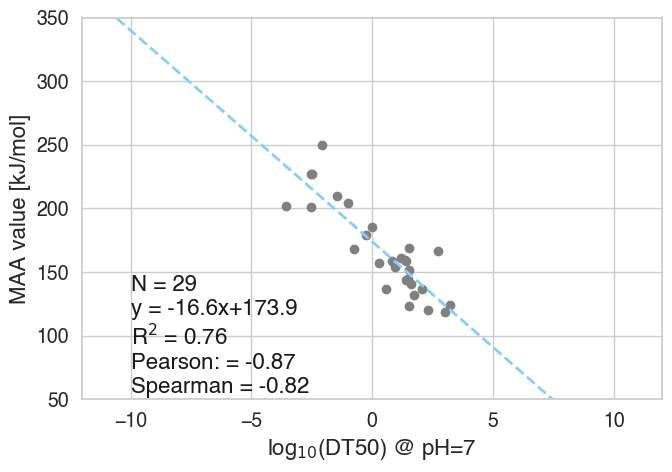

In [55]:
fig = plt.subplots(figsize=(7, 5))
plt.plot(x, y, 'o', color='Grey')

slope, intercept, r_value, p_value, std_err = stats.linregress(list(x), list(y))

plt.plot(np.arange(-12,13,1), slope * np.arange(-12,13,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)
plt.text(-10, 55, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)


plt.xlabel('log$_{10}$(DT50) @ pH='+selected_pH.strip('ph'), fontsize=16)
plt.ylabel('MAA value [kJ/mol]', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-12,12)
plt.ylim(50,350)

plt.tight_layout()
plt.show()

In [56]:
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

# Create SVGs for each smiles
rdkit_mol_list = [Chem.MolFromSmiles(smi) for smi in smiles_list]
imgs = [mol._repr_svg_() for mol in rdkit_mol_list]

# Configure for output in the notebook
output_notebook()

# Load the data into a source and plot
source = ColumnDataSource(
    data={
        "x": x,
        "y": y,
        "imgs": imgs,
        "name": df_stevens['name'].tolist(),
        "smiles": smiles_list,
        "errors": any_errors_list,
        # "imgs": [img for i,img in enumerate(imgs) if any_errors_list[i] == False],
        # "name": [name for i,name in enumerate(name_list) if any_errors_list[i] == False],
        # "smiles": [smi for i,smi in enumerate(smiles_list) if any_errors_list[i] == False],
        # "errors": [e for i,e in enumerate(any_errors_list) if any_errors_list[i] == False],
    }
)
p = figure(max_width=700, height=400)
p.scatter("x", "y", source=source)
p.line(np.arange(-10,11,1), slope * np.arange(-10,11,1) + intercept)
p.sizing_mode = "scale_width"
p.xaxis.axis_label = 'log$_{10}$(DT50) @ pH='+selected_pH.strip('ph')
p.yaxis.axis_label = 'MAA value [kJ/mol]'

# Create tooltips referencing stored images
TOOLTIPS = """\
    <div>
        <div>
            @imgs{safe}
        </div>
        <div>
            <span>@smiles{safe}</span>
        </div>
        <div>
            <span>@name{safe}</span>
        </div>
        <div>
            <span>@errors{safe}</span>
        </div>
        <div>
            <span>($x, $y)</span>
        </div>
    </div>
"""

# Connect tooltips to plot
p.add_tools(HoverTool(tooltips=TOOLTIPS))

# Show figure
show(p)

Loading BokehJS ...

# Data from 10.1016/j.jtice.2021.06.045

In [57]:
df_101016jjtice202106045 = pd.read_csv('/Users/nicolairee/KU_data/hydrolysis/A multiple linear regression approach to the estimation of carboxylic acid ester and lactone alkaline hydrolysis rate constants/101016jjtice202106045_data.csv')
print(df_101016jjtice202106045.shape[0])

display(df_101016jjtice202106045[df_101016jjtice202106045['smiles'].isin(df_101016jjtice202106045[df_101016jjtice202106045.duplicated(subset='smiles')].smiles.tolist())])

df_101016jjtice202106045 = df_101016jjtice202106045.drop_duplicates(subset='smiles')
print(df_101016jjtice202106045.shape[0])
df_101016jjtice202106045.head(2)

33


,name,smiles,calc_maa,calc_error,pred_maa,logkb exp,real_name
5,1,CCOC(=O)C(C)(C)C,112.444458,False,112.144161,-2.80,Ethyl neopentate
26,2,CCOC(=O)C(C)(C)C,112.444458,False,112.144161,-2.77,ethyl pivalate


32


,name,smiles,calc_maa,calc_error,pred_maa,logkb exp,real_name
0,12,COC(C)=O,122.799765,False,122.725904,-0.70,Methyl acetate
1,15,CC(=O)OCCCl,143.619454,False,141.172940,-0.41,2-chloroethyl acetate


In [58]:
smiles_list = df_101016jjtice202106045['smiles'].tolist()
logkb_list = df_101016jjtice202106045['logkb exp'].tolist()
calc_maa_list = df_101016jjtice202106045['calc_maa'].tolist()
any_errors_list = df_101016jjtice202106045['calc_error'].tolist()
pred_maa_list = []

In [59]:
smarts_of_interest = Chem.MolFromSmarts('[#6]([#6,#7])(=[OX1])[#8][#6]') # Esters, "Amides"
smarts_of_interest = Chem.MolFromSmarts('[#6X3;$([#6X3][#6]),$([#6X3H]),$([#6X3][OX2H0]):1](=[OX1:2])[#8X2H0:3][#6;!$(C=[O,N,S]):4]') # Ester

for smiles in smiles_list:
    rdkit_mol = Chem.MolFromSmiles(smiles)

    sites_of_interest = list(set(np.array(rdkit_mol.GetSubstructMatches(smarts_of_interest))[:,0]))
    sites_of_interest = remove_identical_atoms(Chem.AddHs(rdkit_mol), sorted(sites_of_interest))
    
    predMAAs = run_preds(smiles, sites_of_interest)
    pred_maa_list.append(float(max(predMAAs)))

In [62]:
x = logkb_list
y = calc_maa_list
# y = pred_maa_list

slope, intercept, r_value, p_value, std_err = stats.linregress(list(x), list(y))

print(f'MSE:\t\t {metrics.mean_squared_error(x, y):.2f}')
print(f'RMSE:\t\t {metrics.mean_squared_error(x, y, squared=False):.2f}')
print(f'MAE:\t\t {metrics.mean_absolute_error(x, y):.2f}')
print(f'R^2:\t\t {r_value**2:.2f}')
print(f'Pearsonr:\t {stats.pearsonr(x, y).statistic:.2f}')
print(f'SpearmanR:\t {stats.spearmanr(x, y).statistic:.2f}')

MSE:		 21945.77
RMSE:		 148.14
MAE:		 145.53
R^2:		 0.70
Pearsonr:	 0.84
SpearmanR:	 0.86


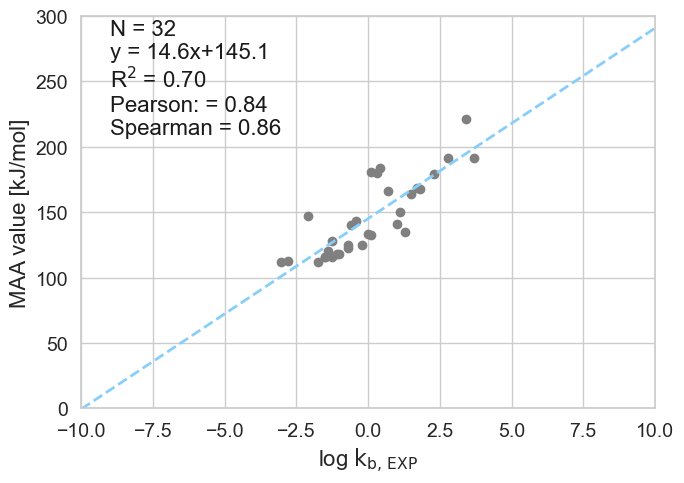

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sns.set_theme(style='whitegrid')

fig = plt.subplots(figsize=(7, 5))
plt.plot(x, y, 'o', color='Grey')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

plt.plot(np.arange(-10,11,1), slope * np.arange(-10,11,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)
plt.text(-9, 210, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)


plt.xlabel('log $\\text{k}_{\\text{b, EXP}}$', fontsize=16)
plt.ylabel('MAA value [kJ/mol]', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-10,10)
plt.ylim(0,300)

plt.tight_layout()
plt.show()

In [22]:
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

# Create SVGs for each smiles
rdkit_mol_list = [Chem.MolFromSmiles(smi) for smi in smiles_list]
imgs = [mol._repr_svg_() for mol in rdkit_mol_list]

# Configure for output in the notebook
output_notebook()

# Load the data into a source and plot
source = ColumnDataSource(
    data={
        "x": x,
        "y": y,
        "imgs": imgs,
        "name": df_101016jjtice202106045['name'].tolist(),
    }
)
p = figure(max_width=700, height=400)
p.scatter("x", "y", source=source)
p.line(np.arange(-10,11,1), slope * np.arange(-10,11,1) + intercept)
p.sizing_mode = "scale_width"
p.xaxis.axis_label = 'Expt. log(k)'
p.yaxis.axis_label = 'Relative Reaction Energies [kJ/mol]'

# Create tooltips referencing stored images
TOOLTIPS = """\
    <div>
        <div>
            @imgs{safe}
        </div>
        <div>
            <span>@smiles{safe}</span>
        </div>
        <div>
            <span>@name{safe}</span>
        </div>
        <div>
            <span>@errors{safe}</span>
        </div>
        <div>
            <span>($x, $y)</span>
        </div>
    </div>
"""

# Connect tooltips to plot
p.add_tools(HoverTool(tooltips=TOOLTIPS))

# Show figure
show(p)

Loading BokehJS ...

# Combine data

pH is 7 for stevens data and probably alkaline for 10.1016/j.jtice.2021.06.045 data

In [23]:
df_stevens

,name,smiles,calc_maa,calc_error,pred_maa,DT50val (ph:7),real_name,ref
0,125,CNC(=O)Oc1cccc2c1OC(C)(C)C2,269.073859,True,149.178535,24.000000,Carbofuran,"EFSA (European Food Safety Authority), 2004a. ..."
1,122,CNC(=O)Oc1cccc2c1OC(C)(C)O2,268.203134,True,155.689072,2.000000,Bendiocarb,Bendiocarb - WHO Specifications and Evaluation...
2,186,CCOC(=O)CCN(SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2)C(C)C,169.872016,False,168.897238,16.200000,Benfuracarb,EFSA (European Food Safety Authority). 2004a. ...
3,132,COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(C)nc(OC)n1,242.319822,True,133.961784,197.000000,Metsulfuron-methyl,EFSA (European Food Safety Authority). 2013.\n...
4,105,CC(=O)OC(C)=O,250.387156,True,226.417377,0.003190,Acetic anhydride,"Davis, K.R. and Hogg, J.L. Transition-state st..."
5,110,CC1(C)C(=O)OC(=O)C1(C)C,218.769938,False,214.410326,0.035600,Tetramethylsuccinic anhydride,"Bunton, C.A. et al. The hydrolysis of carboxyl..."
6,148,COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(OC(F)F)cc(...,255.901706,True,133.257195,1080.000000,Primisulfuron methyl,"Dinelli, G. et al. Hydrolytic Dissipation of F..."
7,96,CC(C)=NOCCOC(=O)[C@@H](C)Oc1ccc(Oc2cnc3cc(Cl)c...,160.930878,False,162.164694,32.000000,Propaquizafop,"EFSA (European Food Safety Authority), 2006. D..."
8,133,COC(=O)c1cccc(C)c1S(=O)(=O)NC(=O)Nc1nc(OCC(F)(...,249.161759,True,136.339945,32.000000,Triflusulfuron-methyl,EFSA (European Food Safety Authority). 2007. D...
9,123,CCOC(=O)Nc1cccc(OC(=O)Nc2ccccc2)c1,179.787205,False,177.970279,0.550000,Desmedipham,European Commission: Health & Consumer Protect...


In [24]:
df_stevens['logkb exp'] = np.log10((np.log(2)/df_stevens['DT50val (ph:7)'])/(60*60*24))
df_stevens

,name,smiles,calc_maa,calc_error,pred_maa,DT50val (ph:7),real_name,ref,logkb exp
0,125,CNC(=O)Oc1cccc2c1OC(C)(C)C2,269.073859,True,149.178535,24.000000,Carbofuran,"EFSA (European Food Safety Authority), 2004a. ...",-6.475900
1,122,CNC(=O)Oc1cccc2c1OC(C)(C)O2,268.203134,True,155.689072,2.000000,Bendiocarb,Bendiocarb - WHO Specifications and Evaluation...,-5.396718
2,186,CCOC(=O)CCN(SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2)C(C)C,169.872016,False,168.897238,16.200000,Benfuracarb,EFSA (European Food Safety Authority). 2004a. ...,-6.305203
3,132,COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(C)nc(OC)n1,242.319822,True,133.961784,197.000000,Metsulfuron-methyl,EFSA (European Food Safety Authority). 2013.\n...,-7.390155
4,105,CC(=O)OC(C)=O,250.387156,True,226.417377,0.003190,Acetic anhydride,"Davis, K.R. and Hogg, J.L. Transition-state st...",-2.599479
5,110,CC1(C)C(=O)OC(=O)C1(C)C,218.769938,False,214.410326,0.035600,Tetramethylsuccinic anhydride,"Bunton, C.A. et al. The hydrolysis of carboxyl...",-3.647138
6,148,COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(OC(F)F)cc(...,255.901706,True,133.257195,1080.000000,Primisulfuron methyl,"Dinelli, G. et al. Hydrolytic Dissipation of F...",-8.129112
7,96,CC(C)=NOCCOC(=O)[C@@H](C)Oc1ccc(Oc2cnc3cc(Cl)c...,160.930878,False,162.164694,32.000000,Propaquizafop,"EFSA (European Food Safety Authority), 2006. D...",-6.600838
8,133,COC(=O)c1cccc(C)c1S(=O)(=O)NC(=O)Nc1nc(OCC(F)(...,249.161759,True,136.339945,32.000000,Triflusulfuron-methyl,EFSA (European Food Safety Authority). 2007. D...,-6.600838
9,123,CCOC(=O)Nc1cccc(OC(=O)Nc2ccccc2)c1,179.787205,False,177.970279,0.550000,Desmedipham,European Commission: Health & Consumer Protect...,-4.836051


In [25]:
df_101016jjtice202106045

,name,smiles,calc_maa,calc_error,pred_maa,logkb exp,real_name
0,12,COC(C)=O,122.799765,False,122.725904,-0.70,Methyl acetate
1,15,CC(=O)OCCCl,143.619454,False,141.172940,-0.41,2-chloroethyl acetate
2,23,CCOC(=O)C(C)Br,140.762357,False,128.862762,1.00,ethyl 2-bromopropionate
3,6,CCOC(=O)C(C)C,115.803594,False,116.398770,-1.49,ethyl isobutyrate
4,24,CCOC(=O)CF,150.457429,False,154.410537,1.10,Ethyl fluoroacetate
5,1,CCOC(=O)C(C)(C)C,112.444458,False,112.144161,-2.80,Ethyl neopentate
6,31,CCOC(=O)C(Cl)(Cl)Cl,221.438940,False,181.129803,3.40,Ethyl trichloroacetate
7,14,CC(=O)OC1CC1,140.202939,False,141.347660,-0.60,Cyclopropyl acetate
8,13,COCCOC(C)=O,125.003576,False,129.524973,-0.69,2-methoxyethyl acetate
9,30,CCOC(=O)C(Cl)Cl,191.405219,False,156.713073,2.80,Ethyl dichloroacetate


In [26]:
df_101016jjtice202106045['DT50val (ph:7)'] = (( np.log(2)/ 10**(df_101016jjtice202106045['logkb exp']) ) / (60*60*24)) * 10**(12-7) #* 10**(14-9) * 10**(7-7)
df_101016jjtice202106045

,name,smiles,calc_maa,calc_error,pred_maa,logkb exp,real_name,DT50val (ph:7)
0,12,COC(C)=O,122.799765,False,122.725904,-0.70,Methyl acetate,4.020793
1,15,CC(=O)OCCCl,143.619454,False,141.172940,-0.41,2-chloroethyl acetate,2.062109
2,23,CCOC(=O)C(C)Br,140.762357,False,128.862762,1.00,ethyl 2-bromopropionate,0.080225
3,6,CCOC(=O)C(C)C,115.803594,False,116.398770,-1.49,ethyl isobutyrate,24.792009
4,24,CCOC(=O)CF,150.457429,False,154.410537,1.10,Ethyl fluoroacetate,0.063725
5,1,CCOC(=O)C(C)(C)C,112.444458,False,112.144161,-2.80,Ethyl neopentate,506.187852
6,31,CCOC(=O)C(Cl)(Cl)Cl,221.438940,False,181.129803,3.40,Ethyl trichloroacetate,0.000319
7,14,CC(=O)OC1CC1,140.202939,False,141.347660,-0.60,Cyclopropyl acetate,3.193829
8,13,COCCOC(C)=O,125.003576,False,129.524973,-0.69,2-methoxyethyl acetate,3.929269
9,30,CCOC(=O)C(Cl)Cl,191.405219,False,156.713073,2.80,Ethyl dichloroacetate,0.001271


In [27]:
df_combined = pd.concat([df_stevens, df_101016jjtice202106045])
df_combined = df_combined.drop_duplicates(subset='smiles')
df_combined

,name,smiles,calc_maa,calc_error,pred_maa,DT50val (ph:7),real_name,ref,logkb exp
0,125,CNC(=O)Oc1cccc2c1OC(C)(C)C2,269.073859,True,149.178535,24.000000,Carbofuran,"EFSA (European Food Safety Authority), 2004a. ...",-6.475900
1,122,CNC(=O)Oc1cccc2c1OC(C)(C)O2,268.203134,True,155.689072,2.000000,Bendiocarb,Bendiocarb - WHO Specifications and Evaluation...,-5.396718
2,186,CCOC(=O)CCN(SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2)C(C)C,169.872016,False,168.897238,16.200000,Benfuracarb,EFSA (European Food Safety Authority). 2004a. ...,-6.305203
3,132,COC(=O)c1ccccc1S(=O)(=O)NC(=O)Nc1nc(C)nc(OC)n1,242.319822,True,133.961784,197.000000,Metsulfuron-methyl,EFSA (European Food Safety Authority). 2013.\n...,-7.390155
4,105,CC(=O)OC(C)=O,250.387156,True,226.417377,0.003190,Acetic anhydride,"Davis, K.R. and Hogg, J.L. Transition-state st...",-2.599479
...,...,...,...,...,...,...,...,...,...
28,10,CCCOC(C)=O,118.415633,False,118.945630,10.099775,Butyl acetate,NaN,-1.100000
29,26,CCOC(=O)CCl,164.026198,False,162.659665,0.025369,Ethyl chloroacetate,NaN,1.500000
30,3,O=C(OCc1ccccc1)c1ccccc1,146.881710,False,139.505166,100.997755,benzyl benzoate,NaN,-2.100000
31,21,CCc1cccc(OC(C)=O)c1,183.627454,False,182.772643,0.319383,m-Ethylphenyl acetate,NaN,0.400000


In [ ]:
df_cae[df_cae['canon_smiles'].isin(df_combined['smiles'].tolist())]

In [ ]:
df_cae = pd.read_pickle('/Users/nicolairee/KU_data/hydrolysis/A multiple linear regression approach to the estimation of carboxylic acid ester and lactone alkaline hydrolysis rate constants/curated_CAEhydrolysis.pkl')
df_combined[df_combined['smiles'].isin(df_cae['canon_smiles'].tolist())]

,name,smiles,calc_maa,calc_error,pred_maa,DT50val (ph:7),real_name,ref,logkb exp
0,12,COC(C)=O,122.799765,False,122.725904,4.020793,Methyl acetate,NaN,-0.70
1,15,CC(=O)OCCCl,143.619454,False,141.172940,2.062109,2-chloroethyl acetate,NaN,-0.41
2,23,CCOC(=O)C(C)Br,140.762357,False,128.862762,0.080225,ethyl 2-bromopropionate,NaN,1.00
3,6,CCOC(=O)C(C)C,115.803594,False,116.398770,24.792009,ethyl isobutyrate,NaN,-1.49
4,24,CCOC(=O)CF,150.457429,False,154.410537,0.063725,Ethyl fluoroacetate,NaN,1.10
5,1,CCOC(=O)C(C)(C)C,112.444458,False,112.144161,506.187852,Ethyl neopentate,NaN,-2.80
6,31,CCOC(=O)C(Cl)(Cl)Cl,221.438940,False,181.129803,0.000319,Ethyl trichloroacetate,NaN,3.40
7,14,CC(=O)OC1CC1,140.202939,False,141.347660,3.193829,Cyclopropyl acetate,NaN,-0.60
8,13,COCCOC(C)=O,125.003576,False,129.524973,3.929269,2-methoxyethyl acetate,NaN,-0.69
9,30,CCOC(=O)C(Cl)Cl,191.405219,False,156.713073,0.001271,Ethyl dichloroacetate,NaN,2.80


In [29]:
smiles_list = df_combined['smiles'].tolist()
# logkb_list = df_combined['logkb exp'].tolist()
logkb_list = df_combined['DT50val (ph:7)'].tolist()
calc_maa_list = df_combined['calc_maa'].tolist()
any_errors_list = df_combined['calc_error'].tolist()
pred_maa_list = []

In [30]:
smarts_of_interest = Chem.MolFromSmarts('[#6X3](=[OX1])[#8][#6]') # Esters, "Amides"
# smarts_of_interest = Chem.MolFromSmarts('[#6X3;$([#6X3][#6]),$([#6X3H]),$([#6X3][OX2H0]):1](=[OX1:2])[#8X2H0:3][#6;!$(C=[O,N,S]):4]') # Ester

for smiles in smiles_list:
    rdkit_mol = Chem.MolFromSmiles(smiles)

    sites_of_interest = list(set(np.array(rdkit_mol.GetSubstructMatches(smarts_of_interest))[:,0]))
    sites_of_interest = remove_identical_atoms(Chem.AddHs(rdkit_mol), sorted(sites_of_interest))
    
    predMAAs = run_preds(smiles, sites_of_interest)
    pred_maa_list.append(float(max(predMAAs)))

In [31]:
x = np.log10(logkb_list)
# y = calc_maa_list
y = pred_maa_list

slope, intercept, r_value, p_value, std_err = stats.linregress(list(x), list(y))

print(f'MSE:\t\t {metrics.mean_squared_error(x, y):.2f}')
print(f'RMSE:\t\t {metrics.mean_squared_error(x, y, squared=False):.2f}')
print(f'MAE:\t\t {metrics.mean_absolute_error(x, y):.2f}')
print(f'R^2:\t\t {r_value**2:.2f}')
print(f'Pearsonr:\t {stats.pearsonr(x, y).statistic:.2f}')
print(f'SpearmanR:\t {stats.spearmanr(x, y).statistic:.2f}')

MSE:		 24737.29
RMSE:		 157.28
MAE:		 154.02
R^2:		 0.47
Pearsonr:	 -0.69
SpearmanR:	 -0.69


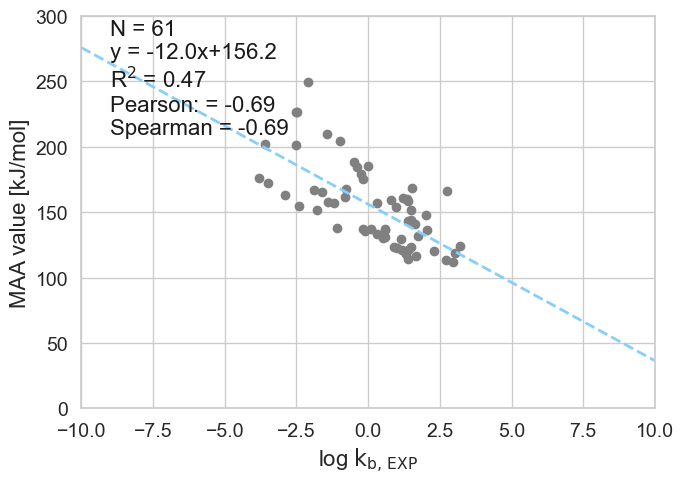

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sns.set_theme(style='whitegrid')

fig = plt.subplots(figsize=(7, 5))
plt.plot(x, y, 'o', color='Grey')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(x), list(y))

plt.plot(np.arange(-10,11,1), slope * np.arange(-10,11,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)
plt.text(-9, 210, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)


plt.xlabel('log $\\text{k}_{\\text{b, EXP}}$', fontsize=16)
plt.ylabel('MAA value [kJ/mol]', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-10,10)
plt.ylim(0,300)

plt.tight_layout()
plt.show()

In [33]:
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

# Create SVGs for each smiles
rdkit_mol_list = [Chem.MolFromSmiles(smi) for smi in smiles_list]
imgs = [mol._repr_svg_() for mol in rdkit_mol_list]

# Configure for output in the notebook
output_notebook()

# Load the data into a source and plot
source = ColumnDataSource(
    data={
        "x": x,
        "y": y,
        "imgs": imgs,
        "name": df_combined['name'].tolist(),
        "smiles": smiles_list,
        "errors": any_errors_list,
        # "imgs": [img for i,img in enumerate(imgs) if any_errors_list[i] == False],
        # "name": [name for i,name in enumerate(name_list) if any_errors_list[i] == False],
        # "smiles": [smi for i,smi in enumerate(smiles_list) if any_errors_list[i] == False],
        # "errors": [e for i,e in enumerate(any_errors_list) if any_errors_list[i] == False],
    }
)
p = figure(max_width=700, height=400)
p.scatter("x", "y", source=source)
p.line(np.arange(-10,11,1), slope * np.arange(-10,11,1) + intercept)
p.sizing_mode = "scale_width"
p.xaxis.axis_label = 'log$_{10}$(DT50) @ pH='+selected_pH.strip('ph')
p.yaxis.axis_label = 'MAA value [kJ/mol]'

# Create tooltips referencing stored images
TOOLTIPS = """\
    <div>
        <div>
            @imgs{safe}
        </div>
        <div>
            <span>@smiles{safe}</span>
        </div>
        <div>
            <span>@name{safe}</span>
        </div>
        <div>
            <span>@errors{safe}</span>
        </div>
        <div>
            <span>($x, $y)</span>
        </div>
    </div>
"""

# Connect tooltips to plot
p.add_tools(HoverTool(tooltips=TOOLTIPS))

# Show figure
show(p)

Loading BokehJS ...

In [15]:
df_data = pd.read_csv('/Users/nicolairee/KU_data/hydrolysis/A multiple linear regression approach to the estimation of carboxylic acid ester and lactone alkaline hydrolysis rate constants/stevens_mlr_cae.csv')
df_SI = pd.read_csv('/Users/nicolairee/KU_data/hydrolysis/A multiple linear regression approach to the estimation of carboxylic acid ester and lactone alkaline hydrolysis rate constants/CAEHydrolysis_SI.csv')

df = pd.concat([df_data,df_SI], axis=1)
df = df[df['QSAR 1/2'] != 1]

df_train = df[df['Status'] == 'In']
df_test = df[df['Status'] == 'In-AD']

In [16]:
smarts_of_interest = Chem.MolFromSmarts('[#6X3](=[OX1])[#8][#6]') # Esters, "Amides"
# smarts_of_interest = Chem.MolFromSmarts('[#6X3;$([#6X3][#6]),$([#6X3H]),$([#6X3][OX2H0]):1](=[OX1:2])[#8X2H0:3][#6;!$(C=[O,N,S]):4]') # Ester


smiles_list = df_test['canon_smiles'].tolist()
pred_maa_list = []

for smiles in smiles_list:
    rdkit_mol = Chem.MolFromSmiles(smiles)

    sites_of_interest = list(set(np.array(rdkit_mol.GetSubstructMatches(smarts_of_interest))[:,0]))
    sites_of_interest = remove_identical_atoms(Chem.AddHs(rdkit_mol), sorted(sites_of_interest))
    
    predMAAs = run_preds(smiles, sites_of_interest)
    pred_maa_list.append(float(max(predMAAs)))

In [17]:
x = df_test['Expt. log(k)']
y = pred_maa_list

slope, intercept, r_value, p_value, std_err = stats.linregress(list(x), list(y))

print(f'N:\t\t {len(x)}')
print(f'MSE:\t\t {metrics.mean_squared_error(x, y):.3f}')
print(f'RMSE:\t\t {metrics.mean_squared_error(x, y, squared=False):.3f}')
print(f'MAE:\t\t {metrics.mean_absolute_error(x, y):.3f}')
print(f'R^2:\t\t {r_value**2:.2f}')
print(f'Pearsonr:\t {stats.pearsonr(x, y).statistic:.2f}')
print(f'SpearmanR:\t {stats.spearmanr(x, y).statistic:.2f}')

N:		 43
MSE:		 22532.342
RMSE:		 150.108
MAE:		 146.482
R^2:		 0.45
Pearsonr:	 0.67
SpearmanR:	 0.73


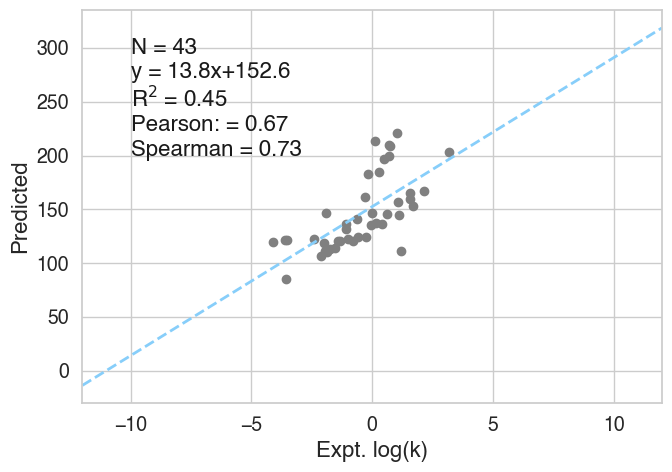

In [20]:
fig = plt.subplots(figsize=(7, 5))
plt.plot(x, y, 'o', color='Grey')

slope, intercept, r_value, p_value, std_err = stats.linregress(list(x), list(y))

plt.plot(np.arange(-12,13,1), slope * np.arange(-12,13,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)
plt.text(-10, 200, f"N = {len(x)} \ny = {slope:.1f}x+{intercept:.1f} \nR$^2$ = {r_value**2:.2f} \nPearson: = {stats.pearsonr(x, y).statistic:.2f} \nSpearman = {stats.spearmanr(x, y).statistic:.2f}", color='k', fontsize=16)


plt.xlabel('Expt. log(k)', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-12,12)
# plt.ylim(-12,12)

plt.tight_layout()
plt.show()